# ASSIGNMENT #5 - UPPER AIR DATA #
Due: 08 April 2024 @ 11:59p

Purpose:\
The purpose of this assignment is to first collect data from an online archive using a user-created function.  The data is then plotted on a map to continue to familiarize with plotting weather data on maps.  

Overview:\
In this assignment you will read in rawinsonde observations in a function and plot that data.


| | UPDATE TO YOUR INFORMATION | 
| :- | :- |
| Created By | Jared W. Marquis |
| Creation Date | 21 January 2024 |
| Course | ATSC 270 - Computer Concepts in Meteorology |

In [ ]:
### UPDATE TO YOUR INFORMATION ###
#information allowing anyone with the code to print the author and contact information
__author__    = "Sam Halvorson"
__contact__   = "samuel.t.halvorson@und.edu"

### IMPORT REQUIRED LIBRARIES ###

In [2]:
import numpy as np
from datetime import datetime

from assignment_5_functions import get_raobs, select_press

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import StationPlot
from metpy.interpolate import interpolate_to_grid, remove_nan_observations

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

### DOWNLOAD OBSERVATIONS FROM  FILE ###
RAwinsonde OBservations (RAOBs) are available from the Iowa State Environmental Mesonet (IEM) archive.  This data can be accessed using the siphon module.  All this will be done within the assignment_5_functions file.  Note, RAOBs don't specify latitude/longitude so we need to add it using a metpy function -> *add_station_lat_lon(data)*.

In [34]:
#grab data from 00Z on 26 December 2023

month = 12
day = 28
time = 12


dt = datetime(2022, month, day, time)
#print(dt)

data = get_raobs(dt)
#print(data)



### SUBSET TO 500MB OBS ###
We'll also do this within a function in the assignment_5_functions file.

In [35]:
data500 = select_press(data, 500)
#print(data500)

### PLOT DATA MAP ###
Use the same map of CONUS as we did for the beginning of surface obs.<br>
No need to thin obs as there aren't a ton of RAOBs.

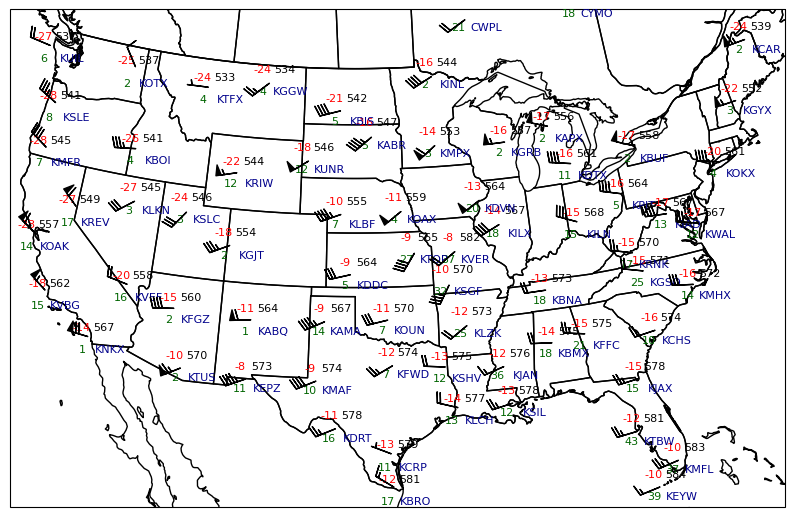

In [36]:
#map projection
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create figure
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

#zoom on the Contiguous United States
ax.set_extent((-120, -75, 23, 50))


#create stationplot
stationplots = StationPlot(ax, data500.longitude, data500.latitude, transform=ccrs.PlateCarree(), clip_on=True, fontsize=8)

#temperature in red
stationplots.plot_parameter((-1,1), data500['temperature'].values, color='red')

#dewpoint DEPRESSION in dark green
stationplots.plot_parameter((-1,-1), (data500["temperature"] - data500['dewpoint'].values), color='darkgreen')

#height (need to format to be the final 3 digits)
stationplots.plot_parameter((1,1), (data500['height'].values), formatter=lambda v: format(v, '.0f')[:3])

#station ID in dark blue
stationplots.plot_text((1.5,-1), data500['station'].values, color='darkblue')

#wind in black
stationplots.plot_barb(data500['u_wind'].values, data500['v_wind'].values, zorder=5)


#save the map as surface_obs.png
plt.savefig("upper_air_500.png")

### CREATE 500mb HEIGHT CONTOURS (ISOHYPSES) ###

In [37]:
#convert the data to x, y, and z locations on the projected map
x,y,z = proj.transform_points(ccrs.PlateCarree(), data500["longitude"].values, data500["latitude"].values).T


#remove nans
mask = ~np.isnan(x)


#interpolate the data to a grid
grdx, grdy, hght = interpolate_to_grid(x[mask], y[mask], data500["height"].values[mask], interp_type="cressman", search_radius=1000000,
                                       minimum_neighbors=3, hres=100000)

### PLOT UPPER AIR STATION PLOTS & CONTOURS ###

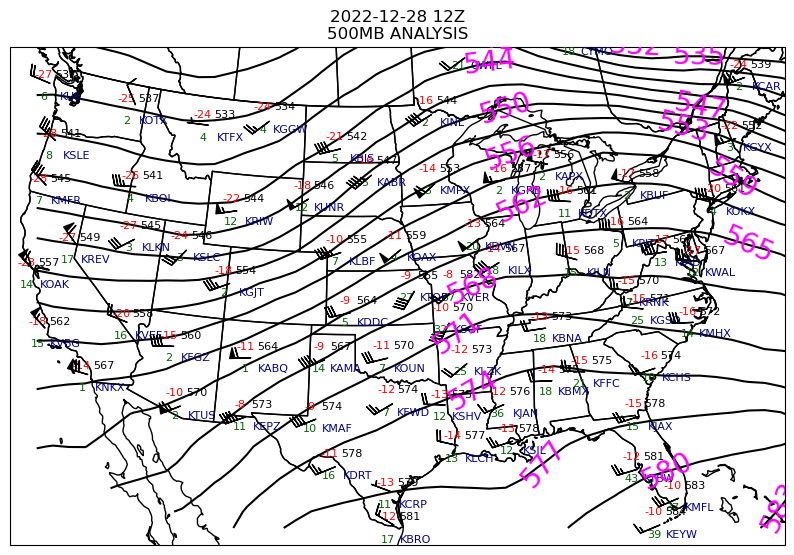

In [38]:
#map projection
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create figure
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable"contour_500.png"
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

#zoom on the Contiguous United States
ax.set_extent((-120, -75, 23, 50))


#create stationplot
stationplots = StationPlot(ax, data500.longitude, data500.latitude, transform=ccrs.PlateCarree(), clip_on=True, fontsize=8)

#temperature in red
stationplots.plot_parameter((-1,1), data500['temperature'].values, color='red')

#dewpoint DEPRESSION in dark green
stationplots.plot_parameter((-1,-1), (data500["temperature"] - data500['dewpoint'].values), color='darkgreen')

#height (need to format to be the final 3 digits)
stationplots.plot_parameter((1,1), (data500['height'].values), formatter=lambda v: format(v, '.0f')[:3])

#station ID in dark blue
stationplots.plot_text((1.5,-1), data500['station'].values, color='darkblue')

#wind in black
stationplots.plot_barb(data500['u_wind'].values, data500['v_wind'].values, zorder=5)






#plot contours from 4600m to 6000m with 60m interval
clevs = np.arange(4600, 6000, 30)

cs = ax.contour(grdx, grdy, hght, clevs, colors="black")

ax.clabel(cs, inline=True, zorder=10, colors="magenta", fontsize=20, fmt=lambda v: format(v, '.0f')[:3])


#add a title with the date
plt.title(f'{dt.strftime("%Y-%m-%d %HZ")}\n500MB ANALYSIS')

#save the map as contour_500.png
plt.savefig(str(day) + "_" + str(time))